In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

In [ ]:
(train_images,_),(_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images-127.5)/127.5

In [ ]:

def build_generator(latent_dim):
  #Se aumenta la dimensionalidad para no se pierda la información de esa imagen


    # 0 y 1, escala de grises

    #Un modelo para crear una capa de entrada y no de salida
    #Es un modelo de la instancia
    model = models.Sequential()
    #se convierte , se redimensiona
    model.add(layers.Dense(7*7*128,input_dim=latent_dim))
    #se multiplica por el alpha para mejorar el resultado del modelo y acercarlo a valores positivos
    #El mejor modelo a utilizar es el than, por el tipo de gráfica que no desactiva las neuronas.
    #La cantidad de capas especificadas es para ir perfeccionando el modelo
    model.add(layers.LeakyReLU(alpha=0.2))

    #Capa de redinsionamiento
    model.add(layers.Reshape((7,7,128)))
    #Una red convulusinal es cambiar la dimensión de la imagen para aprender de la imagen

    #Aumentarle la resolución
    #Tiene 64 neuronas. Filtro de matrices de 4 x 4 de imagenes.
    #El strides se mueve de 2 en 2, por filas y columnas, y que mantenga la forma
    model.add(layers.Conv2DTranspose(64,(4,4),strides=(2,2),padding='same'))
    #reajustar el valor con otra capa
    model.add(layers.LeakyReLU(alpha=0.2))
    #La salida es un valor de 1 -1, porque maneja tanh, y deja lo mismo
    model.add(layers.Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',activation='tanh'))

    return model

In [ ]:
def build_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
  model.add(layers. LeakyReLU(alpha=0.2))
  #Apaga un porcentaje de neuronas.  Para prevenir el sobreajuste
  model.add(layers.Dropout (0.4))
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  ##volver un único vector, una capa plana
  model.add(layers.Flatten())
  #tiende a cero o a uno el resultado para realizar la clasificación
  #Sirve para que valores cercanos a cero tengan un asjute más fino de acuerdo a una clasificación que se esta dando
  #que esos vaalores la activen
  #función de eulier para definir si se activa o no

  #realimenta el generador
  #devuelve que tanta probabilidad que la sintentica sea identica a la real
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

4/4 [==============================] - 2s 4ms/step
Epoch 0, D Loss: 0.6798395216464996,G Loss: 0.6822946667671204
4/4 [==============================] - 0s 5ms/step


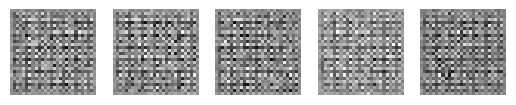

4/4 [==============================] - 0s 3ms/step
Epoch 1200, D Loss: 0.5357511043548584,G Loss: 1.675376534461975
4/4 [==============================] - 0s 5ms/step


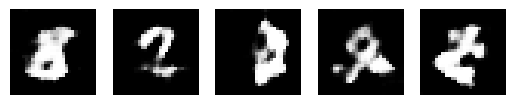

4/4 [==============================] - 0s 4ms/step
Epoch 2400, D Loss: 0.5524967014789581,G Loss: 1.481442928314209
4/4 [==============================] - 0s 5ms/step


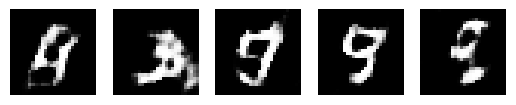

4/4 [==============================] - 0s 4ms/step
Epoch 3600, D Loss: 0.4900238811969757,G Loss: 1.4253989458084106
4/4 [==============================] - 0s 3ms/step


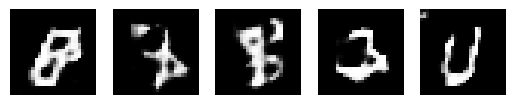

4/4 [==============================] - 0s 4ms/step
Epoch 4800, D Loss: 0.49330461025238037,G Loss: 1.449283480644226
4/4 [==============================] - 0s 4ms/step


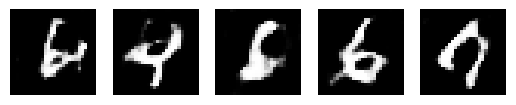

4/4 [==============================] - 0s 3ms/step
Epoch 6000, D Loss: 0.42256955802440643,G Loss: 1.578546166419983
4/4 [==============================] - 0s 3ms/step


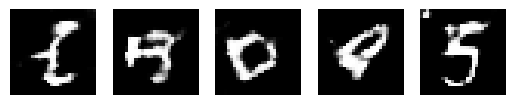

4/4 [==============================] - 0s 5ms/step
Epoch 7200, D Loss: 0.45330221951007843,G Loss: 1.510115623474121
4/4 [==============================] - 0s 6ms/step


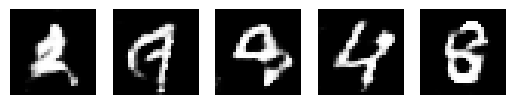

4/4 [==============================] - 0s 6ms/step
Epoch 8400, D Loss: 0.484584704041481,G Loss: 1.3940160274505615
4/4 [==============================] - 0s 4ms/step


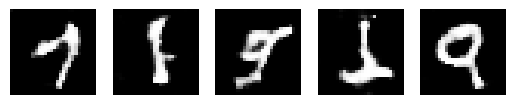

4/4 [==============================] - 0s 3ms/step
Epoch 9600, D Loss: 0.6579287648200989,G Loss: 1.1103076934814453
4/4 [==============================] - 0s 6ms/step


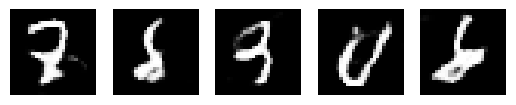

4/4 [==============================] - 0s 5ms/step


In [ ]:
from keras.engine.training import optimizer

#Dimensión del espacio latente
latent_dim=100

discriminator = build_discriminator()
##Es un discrimiador binario, es o no es, por eso se utiliza binary_cross
##Adam, es  mejor porqu
##metrica de precisión, porque para los modelos es la mejor
discriminator.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

generator = build_generator(latent_dim)

discriminator.trainable = False
#Entrada de 100
gan_input = tf.keras.Input(shape=(latent_dim,))
#el generador se entrene
#le doy espacio latente, al generador
x=generator(gan_input)
#La salida es x, la entrada del discrimador
gan_output = discriminator(x)
#espacio latente(ruido) y la salida del modelo
gan = tf.keras.Model(gan_input,gan_output)
#función de perdida cruzada, es un binario
gan.compile(loss='binary_crossentropy',optimizer='adam')

#Entrenamiento
batch_size=128
epochs = 10000
sample_interval =1200

import numpy as np

for epoch in range(epochs):
  #Entrenamiento discriminador
  #un indice, apuntador, para un valor random
  #que sean las imagenes que se entrenaran
  idx = np.random.randint(0,train_images.shape[0],batch_size)
  #trae una imagen por cada epoca
  real_images = train_images[idx]
  #crea el ruido, que seguirá una distribución normal y se definirá con valores de 0 a 1
  #valor de lotes que le enviaré, espacio latente
  noise = np.random.normal(0,1,(batch_size,latent_dim))
  #generador que yo le envié para predecir con la entrada de ruido con distribución normla
  generated_images = generator.predict(noise)
  #un vector de arrego de 1, se debe inicializar sus variables con algo
  real_labels = np.ones((batch_size,1))
  #las etiquetas de las falsas pongale cero
  fake_labels = np.zeros((batch_size,1))


  #calcular la perdida del discriminador para los datos reales, entrenados por lote.  imagenes reales
  d_loss_real = discriminator.train_on_batch(real_images,real_labels)
    #calcular la perdida del discriminador para los datos fake, entrenados por lote.  imagenes fake
  d_loss_fake = discriminator.train_on_batch(generated_images,fake_labels)
  #eso es para calcular la perdida, sumar las dos perdida y la dividirá
  d_loss = 0.5*  np.add(d_loss_real,d_loss_fake)

  #el que se ajusta son los labels

  #Entrenamiento del generador

#generará ese ruido, debía tener una imagen fake.
  noise = np.random.normal(0,1,(batch_size,latent_dim))
  #la red gan por lotes, el ruido y las etiquetas reales, porque la entrada de esa red gan es el ruido y la salida es la real
  #que busca del discriminador
  g_loss = gan.train_on_batch(noise,real_labels)

  if epoch % sample_interval==0:
    #para cada epoca, hacer un modulo, cuando la cantidad de epocas sea igual a cero
    #imprimirá la cantidad de epocas que lleva, perdida del discriminador, perdida de generador
    print(f'Epoch {epoch}, D Loss: {d_loss[0]},G Loss: {g_loss}')

    #Generar imagenes de ejemplo
    #usar el modelo del generador, dele un ruido y genereré la imagen
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5 # Reescalar imágenes a [0,1]

    #crea una figura
    fig,axs = plt.subplots(1,5)
    for i in range(5):
      axs[i].imshow(generated_images[i,:,:,0],cmap='gray')
      axs[i].axis('off')
    plt.show()

In [ ]:
generator.save('generador_model.h5')

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

In [52]:
generator = tf.keras.models.load_model('generador_model.h5')

In [53]:
#fase operación
import numpy as np

num_samples = 10
latent_dim = 100

#genere un ruido, que siga una distribución normal
noise = np.random.normal(0,1,(num_samples,latent_dim))
#lo pondrá en modo predicción
generated_images = generator.predict(noise)

1/1 [==============================] - 0s 74ms/step


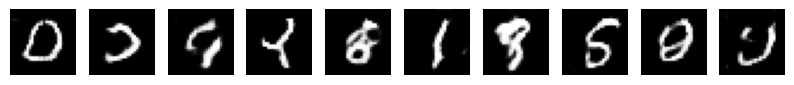

In [54]:
# se dibuja
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,num_samples,figsize=(10,2))
for i in range(num_samples):
  axs[i].imshow(generated_images[i,:,:,0], cmap='gray')
  axs[i].axis('off')
plt.show()

1/1 [==============================] - 0s 17ms/step


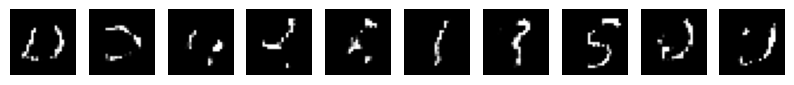

In [55]:
import numpy as np

# Aumentar significativamente los valores en noise
noise *= 5  # Puedes ajustar el factor de escala según tus necesidades

# Generar imágenes usando el generador
generated_images = generator.predict(noise)

# Dibujar las imágenes generadas
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()


In [56]:
noise

array([[ 8.02346739e+00, -1.23255126e-01, -6.07353250e+00,
         4.23957883e+00,  6.88259336e+00,  2.35245289e+00,
         5.98064249e+00, -1.07903090e+01, -1.58167268e+00,
        -9.29415500e+00,  1.17609809e+00,  3.55879205e-01,
        -6.26764204e+00,  2.58684121e+00, -7.30649161e-01,
        -4.81413690e+00, -6.78205836e-01,  8.00006770e+00,
         1.66531865e+00, -2.95278984e+00, -1.01002776e+01,
        -5.42457772e+00,  2.52700721e+00, -8.11071929e+00,
         2.58470346e+00,  3.10024640e+00,  1.20826593e+00,
         2.07277098e+00,  7.95130472e+00, -1.00349695e+00,
         3.17083373e+00, -3.15826175e+00, -3.03334863e+00,
        -1.28695957e+00,  7.02944531e+00,  3.91797278e+00,
        -3.18664029e+00, -1.80307292e-02,  6.61603975e+00,
        -1.52498757e+00,  1.47488639e+00,  8.05480884e-01,
        -8.50541916e+00, -1.17770333e+00, -4.82795253e+00,
         3.92532084e+00,  1.24062788e+00,  1.41549215e+00,
        -4.94280478e+00, -7.02911985e+00,  4.13655671e+0

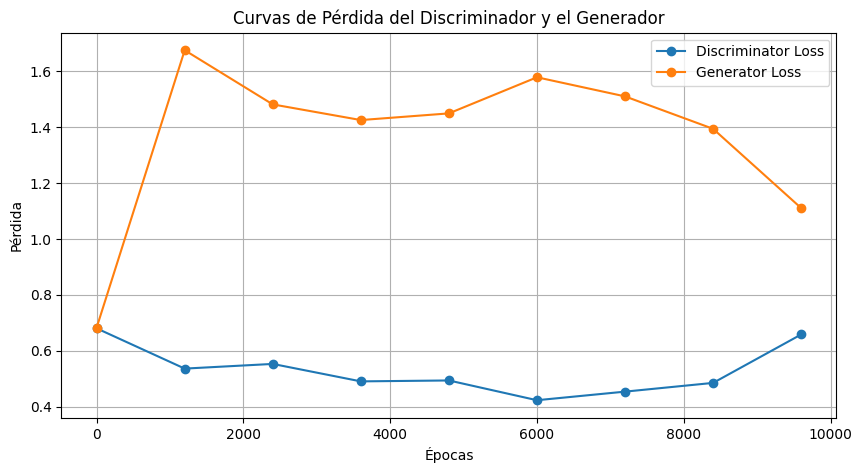

In [ ]:
import matplotlib.pyplot as plt

# Pérdidas proporcionadas en el formato dado
d_losses = [0.6798395216464996, 0.5357511043548584, 0.5524967014789581, 0.4900238811969757, 0.49330461025238037, 0.42256955802440643, 0.45330221951007843, 0.484584704041481, 0.6579287648200989]
g_losses = [0.6822946667671204, 1.675376534461975, 1.481442928314209, 1.4253989458084106, 1.449283480644226, 1.578546166419983, 1.510115623474121, 1.3940160274505615, 1.1103076934814453]

# Número de épocas correspondiente
epochs = [0, 1200, 2400, 3600, 4800, 6000, 7200, 8400, 9600]

# Crear las curvas de pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, d_losses, label='Discriminator Loss', marker='o')
plt.plot(epochs, g_losses, label='Generator Loss', marker='o')

# Personalización del gráfico
plt.title('Curvas de Pérdida del Discriminador y el Generador')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()


A medida que avanzan las épocas, tanto el generador como el discriminador mejoran en sus respectivas tareas. El generador aprende a generar datos más realistas, mientras que el discriminador mejora en su capacidad para distinguir entre datos reales y falsos. La pérdida del generador tiende a disminuir continuamente, mientras que la pérdida del discriminador también disminuye, aunque se observa una fluctuación en la época 6000. En la época 6000, se observa un comportamiento inusual en las curvas. La pérdida del discriminador disminuye abruptamente, mientras que la pérdida del generador aumenta momentáneamente. Esto sugiere que en ese punto, el generador pudo haber logrado una mejora significativa en la generación de datos realistas, lo que temporalmente confundió al discriminador. Esta competencia y adaptación continua entre el generador y el discriminador son características clave de una GAN.

